In [ ]:
import csv
import numpy as np
np.random.seed(0) 
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML-epfl/data

/content/drive/MyDrive/ML-epfl/data


In [ ]:
"""some helper functions for project 1."""


def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1
    
    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids

def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1
    
    return y_pred

def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})


def find_acc(y,y_hat):
  """
  give y and y_hat based on the threshold of 0.5, we compute
  the accuracy

  """
  y,y_hat=np.copy(y), np.copy(y_hat)
  y[np.where(y <= 0.5)] = -1
  y[np.where(y > 0.5)] = 1
  y_hat[np.where(y_hat <= 0.5)] = -1
  y_hat[np.where(y_hat > 0.5)] = 1
  return np.sum(y==y_hat)/len(y)



def poly_M(X,m):

  """
  This function creates new X ( feature matrix ) by concatinating
  X^i from the primitive X matrix for i from 2 to m 

  """
  nan_ids=X==-999
  nan_ids_tmp=np.copy(nan_ids)
  X_tmp=np.copy(X)
  for i in range(2,m+1): 
    X = np.c_[X_tmp**i, X]
    nan_ids= np.c_[nan_ids_tmp, nan_ids]
  X[nan_ids]=-999
  return X

def featureNormalize(X):

  """
  Normalize X by minimizing its mean and deviding by standard deviation
  Note:  we replace -999 elements with 0 after normalaizing by other element of each column
  """
  X_norm = np.copy(X)
  mu = np.zeros(X.shape[1])
  sigma = np.zeros(X.shape[1])

  for j in range(X.shape[1]): 
    nonnan_ids = np.where(X[:,j]!=-999)[0]
    mu[j]=X[nonnan_ids,j].mean()
    sigma[j] = X[nonnan_ids,j].std()
  
  
  for j in range(X.shape[1]): 
    nan_ids = np.where(X[:,j]==-999)[0]
    X_norm[:,j] = (X[:,j]-mu[j])/sigma[j]
    X_norm[nan_ids,j] = 0

  return X_norm, mu, sigma


def prepare_input_data(data,degree=1):
  """
  prepareing the input data
  """
  # valid_rows=np.any(input_data==-999,axis=1)
  # yb, input_data, ids=yb[valid_rows], input_data[valid_rows], ids[valid_rows]

  valid_columns=None
  # valid_columns=np.sum(data==-999,axis=0)<0.3*len(data)
  # data=data[:,valid_columns]
  data= poly_M(data,degree)
  data, mu, sigma = featureNormalize(data)
  m,n= data.shape

  # add a column with number 1 as the bias
  data = np.c_[np.ones((m,1)), data]
  return data, valid_columns,mu, sigma 




def prepare_test_data(data,mu, sigma,degree=1):

  data= poly_M(data,degree)
    
  for j in range(data.shape[1]): 
    nan_ids = np.where(data[:,j]==-999)[0]
    data[:,j] = (data[:,j]-mu[j])/sigma[j]
    data[nan_ids,j] = 0

  m,n= data.shape
  data = np.c_[np.ones((m,1)), data]
  return data

# NOT USED
def upsample_minority(y, X):

  """
  this function is used to upsample minority class 
  """

  minority_class_ids = np.where(y==1)[0]
  majority_class_ids = np.where(y==0)[0]
  extra_minority_ids= np.random.choice(minority_class_ids,
                                       len(majority_class_ids)-len(minority_class_ids),
                                       replace=True)
  new_minority_class_ids= np.concatenate([minority_class_ids , extra_minority_ids])


  return  np.concatenate([y , y[extra_minority_ids]]), np.concatenate([X , X[extra_minority_ids]])


In [ ]:
(yb, input_data, ids)=load_csv_data("train.csv")
# we change the lables from 1 and -1 to 1 and 0
yb=(yb+1)/2
input_data, valid_columns, mu, sigma = prepare_input_data(input_data,degree=9)

input_data.shape

(250000, 271)

In [ ]:
def train_val_split(y, X):

  """
  devide input data to train and validation (80% and 20%)

  """
  train_size= int(X.shape[0]*0.8)
  val_size= X.shape[0]- train_size
  indices = np.random.RandomState(seed=42).permutation(X.shape[0])
  training_idx, val_idx = indices[:train_size], indices[val_size:]
  return X[training_idx,:], X[val_idx,:], y[training_idx], y[val_idx]

train_X, val_X, train_y, val_y = train_val_split(yb, input_data)


In [ ]:
def computeCost(X, y, theta):
  m = len(y);
  h = np.matmul(X,theta);
  return 1/(2*m)*np.linalg.norm(h-y,ord=2)**2;

In [ ]:
def least_squares(y, X):
  X_T=np.transpose(X)
  theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_T,X)),X_T),y)
  train_loss=computeCost(X, y, theta)
  val_loss=computeCost(val_X, val_y, theta)
  train_acc = find_acc(y, np.matmul(X,theta))
  val_acc = find_acc(val_y, np.matmul(val_X,theta))
  print('Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(train_loss, 
                                                                                               val_loss,
                                                                                               train_acc, val_acc))
  return theta
weight=least_squares(train_y, train_X);


Training loss= 0.069448 Val loss= 2.862265 Training acc= 0.818190 Val acc= 0.817195


Streaming output truncated to the last 5000 lines.
Epoch 2: Training loss= 124.377213 Val loss= 151.678181 Training acc= 0.566560 Val acc= 0.565830
Epoch 3: Training loss= 93.969200 Val loss= 120.875936 Training acc= 0.564705 Val acc= 0.564260
Epoch 4: Training loss= 73.830217 Val loss= 98.773152 Training acc= 0.562685 Val acc= 0.562140
Epoch 5: Training loss= 59.916455 Val loss= 82.500775 Training acc= 0.561180 Val acc= 0.560700
Epoch 6: Training loss= 49.907490 Val loss= 70.216220 Training acc= 0.559750 Val acc= 0.559210
Epoch 7: Training loss= 42.437688 Val loss= 60.718908 Training acc= 0.558790 Val acc= 0.558410
Epoch 8: Training loss= 36.680553 Val loss= 53.213929 Training acc= 0.558235 Val acc= 0.558015
Epoch 9: Training loss= 32.120576 Val loss= 47.165633 Training acc= 0.557485 Val acc= 0.557360
Epoch 10: Training loss= 28.425910 Val loss= 42.206193 Training acc= 0.556815 Val acc= 0.556760
Epoch 11: Training loss= 25.375959 Val loss= 38.077952 Training acc= 0.556190 Val acc= 0.5

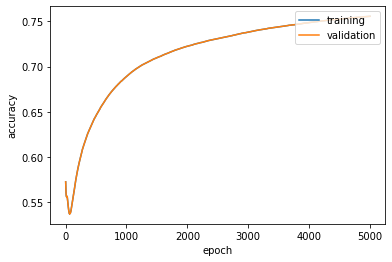

(array([ 3.43889247e-01, -1.14245699e-01,  3.56423052e-02,  1.85728454e-01,
         1.90561304e-01,  4.38652959e-01, -9.24441726e-03, -9.53890386e-02,
        -3.27539025e-03, -9.37055324e-02, -2.92375898e-02, -2.19150900e-01,
        -2.17715583e-01,  4.39070779e-01,  5.81205919e-01, -9.25216490e-02,
         5.49916667e-02,  6.04858914e-01,  3.10305176e-01, -3.69760451e-01,
         3.57773462e-01,  2.05332695e-01,  1.73015227e-03, -8.70024757e-04,
        -2.20153855e-01,  5.09824055e-02, -9.73169857e-02, -2.31033696e-02,
        -3.13502770e-01,  1.72288886e-01,  1.76042487e-01, -1.43283600e-01,
        -1.76339127e-01, -9.23858944e-02, -1.91101021e-01,  3.38459873e-01,
         2.96030629e-01, -7.60328954e-02, -3.06458077e-01,  1.45910883e-02,
        -3.39995680e-01,  1.85948784e-01,  1.77122612e-01, -4.30427575e-01,
        -6.13761958e-02,  1.70763337e-02, -1.23702779e-01, -1.39434632e-01,
         2.93914902e-01,  9.53274567e-02,  7.97404124e-02,  1.69875549e-01,
         1.9

In [ ]:

def least_squares_GD(y, X, theta, num_iters, gamma, show=False):
  m = len(y);
  train_loss= np.zeros(num_iters);
  val_loss = np.zeros(num_iters);
  train_acc= np.zeros(num_iters);
  val_acc = np.zeros(num_iters);
  models=[]
  for iter in range (num_iters):
    
    # update weights
    theta = theta - gamma/m * np.matmul(np.transpose(X),(np.matmul(X,theta)-y))
    # compute losses
    train_loss[iter] = computeCost(X, y, theta)
    val_loss[iter] = computeCost(val_X, val_y, theta)
    train_acc[iter] = find_acc(y, np.matmul(X,theta))
    val_acc[iter] = find_acc(val_y, np.matmul(val_X,theta))
    models.append(np.copy(theta))
    print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[iter], val_loss[iter], train_acc[iter], val_acc[iter]))
  best_model_idx=np.argmin(val_loss)
  print("Best model info *** :")
  print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[best_model_idx],val_loss[best_model_idx],
                                                                                                         train_acc[best_model_idx],val_acc[best_model_idx],))
  
  if show:
    plt.plot(range(1,num_iters+1), train_acc)
    plt.plot(range(1,num_iters+1), train_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
  return models[best_model_idx], train_loss[best_model_idx]


least_squares_GD(train_y,train_X,np.random.rand(train_X.shape[1]),5000,0.01,show=True)



In [ ]:

def least_squares_SGD(y, X, theta, num_iters, gamma, show=False):
    m = len(y);
    train_loss= np.zeros(num_iters);
    val_loss = np.zeros(num_iters);
    train_acc= np.zeros(num_iters);
    val_acc = np.zeros(num_iters);
    models=[]
    for iter in range (num_iters):
      random_idx=np.random.randint(m)
      # update weights
      theta = theta - gamma * np.transpose(X[random_idx])*(np.matmul(X[random_idx],theta)-y[random_idx])
      train_loss[iter] = computeCost(X, y, theta)
      val_loss[iter] = computeCost(val_X, val_y, theta)
      train_acc[iter] = find_acc(y, np.matmul(X,theta))
      val_acc[iter] = find_acc(val_y, np.matmul(val_X,theta))
      models.append(np.copy(theta))
      print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[iter], val_loss[iter],
                                                                                                              train_acc[iter], val_acc[iter]))
    best_model_idx=np.argmin(val_loss)
    print("Best model info *** :")
    print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[best_model_idx],val_loss[best_model_idx],
                                                                                                         train_acc[best_model_idx],val_acc[best_model_idx],))
  
    if show:
      plt.plot(range(1,num_iters+1), train_loss)
      plt.plot(range(1,num_iters+1), val_loss)
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.legend(['training', 'validation'], loc='upper right')
      plt.show()
    return models[best_model_idx], train_loss[best_model_idx]
least_squares_SGD(train_y,train_X,np.random.rand(train_X.shape[1]),10000,0.001,show=True)


In [ ]:
train_loss1=train_loss
val_loss1 =val_loss
train_acc1=train_acc
val_acc1 = val_acc

In [ ]:
def computeCost_ridge(X, y, theta, lambda_):
  m = len(y);
  h = np.matmul(X,theta);
  return 1/(2*m)*np.linalg.norm(h-y,ord=2)**2+ lambda_*np.linalg.norm(theta,ord=2)**2

In [ ]:
def ridge_regression(y, X, lambda_):
  X_T=np.transpose(X)
  n=len(X_T)
  m = len(y)
  I=np.identity(n)
  lambda_prime=lambda_*(2*m);
  # find the final weights
  theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_T,X)+lambda_prime*I),X_T),y)
  train_loss=computeCost_ridge(X, y, theta, lambda_)
  val_loss=computeCost_ridge(val_X, val_y, theta, lambda_)
  train_acc = find_acc(y, np.matmul(X,theta))
  val_acc = find_acc(val_y, np.matmul(val_X,theta))
  print('Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(train_loss, 
                                                                                               val_loss,
                                                                                               train_acc, val_acc))
  return theta
ridge_regression(train_y, train_X, 0);


Training loss= 0.069448 Val loss= 2.862265 Training acc= 0.818190 Val acc= 0.817195


Epoch 0: Training loss= 5.647390 Val loss= 5.582713 Training acc= 0.570545 Val acc= 0.570065
Epoch 1: Training loss= 5.538080 Val loss= 5.474394 Training acc= 0.571180 Val acc= 0.570510
Epoch 2: Training loss= 5.429677 Val loss= 5.367019 Training acc= 0.571600 Val acc= 0.571015
Epoch 3: Training loss= 5.322211 Val loss= 5.260616 Training acc= 0.572175 Val acc= 0.571870
Epoch 4: Training loss= 5.215709 Val loss= 5.155215 Training acc= 0.573000 Val acc= 0.572665
Epoch 5: Training loss= 5.110197 Val loss= 5.050843 Training acc= 0.573825 Val acc= 0.573510
Epoch 6: Training loss= 5.005704 Val loss= 4.947531 Training acc= 0.574525 Val acc= 0.574240
Epoch 7: Training loss= 4.902260 Val loss= 4.845309 Training acc= 0.575250 Val acc= 0.575175
Epoch 8: Training loss= 4.799893 Val loss= 4.744208 Training acc= 0.576100 Val acc= 0.576125
Epoch 9: Training loss= 4.698634 Val loss= 4.644255 Training acc= 0.576960 Val acc= 0.577135
Epoch 10: Training loss= 4.598511 Val loss= 4.545479 Training acc= 0.5

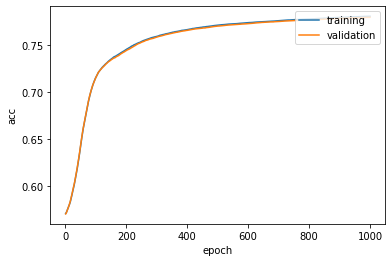

(array([-1.01558939,  0.0973676 ,  0.54742838,  0.0714579 ,  0.74239577,
         0.34170413,  0.41889476,  0.81485606, -0.45861957,  0.69398313,
         0.20582739,  0.28272049,  0.33057366,  0.21512716,  0.76425041,
         0.04887915, -0.12463207, -0.04130119, -0.06429992,  0.04648961,
         0.12428062, -0.17251569, -0.25325788, -0.41613792,  0.13064606,
         0.16872904, -0.13628496,  0.73734904, -0.22935483,  0.12720947,
        -0.31765264,  0.21514093,  0.27070964,  0.7452129 ,  0.1449081 ,
         0.19811124,  0.89513085,  0.65313762,  0.02679643,  0.73863562,
        -0.22681053, -0.13503007, -0.31819657, -0.19212465,  0.91646902,
         0.21199492,  0.18129228,  0.65118436,  0.03622469,  0.05688161,
         0.42649866, -0.0841772 ,  0.46535803,  0.05510449,  0.57889717,
        -0.19188393, -0.09897433, -0.06499733,  0.25292338, -0.11424947,
         0.47649948, -0.04856382,  0.18746415,  0.14047515,  0.11375601,
         0.65731294,  0.69912811,  0.20841866, -0.1

In [ ]:



def sigmoid(z):
  return 1/(1+np.exp(-z))
def logistic_regression(y, X, theta, num_iters, gamma, show=False):
  y=y.astype(dtype=np.float128)
  X=X.astype(dtype=np.float128)
  theta=theta.astype(dtype=np.float128)

  m = len(y);
  train_loss= np.zeros(num_iters)
  val_loss = np.zeros(num_iters)
  train_acc= np.zeros(num_iters)
  val_acc = np.zeros(num_iters)
  models=[]

  for iter in range (num_iters):
    h = sigmoid(np.matmul(X,theta))
    train_loss[iter] =  1/m*np.sum(np.log(1+np.exp(np.matmul(X,theta)))-y*np.matmul(X,theta))
    # update weights
    theta = theta - gamma * 1/m *np.matmul(np.transpose(X),(h-y))
    val_h = sigmoid(np.matmul(val_X,theta))
    val_loss[iter] =  1/m*np.sum(np.log(1+np.exp(np.matmul(val_X,theta)))-val_y*np.matmul(val_X,theta))
    train_acc[iter] = find_acc(y, h)
    val_acc[iter] = find_acc(val_y, val_h)
    models.append(np.copy(theta))
    print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[iter], val_loss[iter], train_acc[iter], val_acc[iter]))

  best_model_idx=np.argmin(val_loss)
  print("Best model info *** :")
  print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[best_model_idx],val_loss[best_model_idx],
                                                                                                         train_acc[best_model_idx],val_acc[best_model_idx],))
  if show:
    plt.plot(range(1,num_iters+1), train_acc)
    plt.plot(range(1,num_iters+1), val_acc)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
  return models[best_model_idx], train_loss[best_model_idx]
logistic_regression(train_y,train_X,np.random.rand(train_X.shape[1]),1000,0.1,show=True)


Epoch 0: Training loss= 5.369292 Val loss= 5.298313 Training acc= 0.567460 Val acc= 0.567475
Epoch 1: Training loss= 5.262680 Val loss= 5.192937 Training acc= 0.568345 Val acc= 0.568475
Epoch 2: Training loss= 5.157172 Val loss= 5.088699 Training acc= 0.569250 Val acc= 0.569285
Epoch 3: Training loss= 5.052790 Val loss= 4.985621 Training acc= 0.569885 Val acc= 0.570325
Epoch 4: Training loss= 4.949557 Val loss= 4.883723 Training acc= 0.570865 Val acc= 0.571325
Epoch 5: Training loss= 4.847493 Val loss= 4.783026 Training acc= 0.571730 Val acc= 0.572125
Epoch 6: Training loss= 4.746619 Val loss= 4.683546 Training acc= 0.572535 Val acc= 0.573210
Epoch 7: Training loss= 4.646956 Val loss= 4.585301 Training acc= 0.573625 Val acc= 0.574255
Epoch 8: Training loss= 4.548524 Val loss= 4.488308 Training acc= 0.574755 Val acc= 0.575455
Epoch 9: Training loss= 4.451339 Val loss= 4.392582 Training acc= 0.575820 Val acc= 0.576365
Epoch 10: Training loss= 4.355417 Val loss= 4.298134 Training acc= 0.5

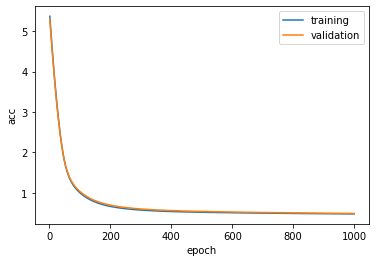

(array([-1.03792565, -0.05472914,  0.66465482, -0.19791621,  0.3923722 ,
         0.7053156 ,  0.35322517,  0.02941614, -0.59815567,  0.33135963,
        -0.07821835, -0.01583748,  0.11156517, -0.18513925,  0.3970438 ,
        -0.24436808, -0.14798586,  0.67561491, -0.15047611, -0.12242078,
         0.81311209, -0.00981819, -0.07846336, -0.01107987,  0.31064563,
         0.20887154,  0.34209353,  0.61501812, -0.02046568, -0.21476263,
        -0.04173014,  0.49237963,  0.12382912, -0.0598286 ,  0.39596944,
         0.49369166,  0.1980445 ,  0.12017558, -0.27215413,  0.29685253,
         0.31531868, -0.04944508, -0.19139139,  0.01560707,  0.45117695,
        -0.33953084,  0.26763053,  0.5114505 , -0.09394895, -0.00361067,
         0.72407263, -0.14752789,  0.49490723, -0.38382483,  0.66536356,
        -0.33385185, -0.23910693,  0.474155  ,  0.09797703,  0.12435404,
         0.0307833 ,  0.30006155,  0.42443833,  0.39090228,  0.83815317,
        -0.25036862, -0.03877373,  0.66798801, -0.6

In [ ]:


def sigmoid(z):
  return 1/(1+np.exp(-z))
def reg_logistic_regression(y, X, lambda_, theta, num_iters, gamma, show=False):
  y=y.astype(dtype=np.float128)
  X=X.astype(dtype=np.float128)
  theta=theta.astype(dtype=np.float128)


  m = len(y);
  train_loss= np.zeros(num_iters)
  val_loss = np.zeros(num_iters)
  train_acc= np.zeros(num_iters)
  val_acc = np.zeros(num_iters)
  models=[]

  for iter in range (num_iters):
    h = sigmoid(np.matmul(X,theta))
    train_loss[iter] =  1/m*np.sum(np.log(1+np.exp(np.matmul(X,theta)))-y*np.matmul(X,theta))+ lambda_/(2*m)*np.linalg.norm(theta[1:],ord=2)**2
    # update weights
    theta = theta - gamma * 1/m * ( np.matmul(np.transpose(X),(h-y)) + lambda_/m *np.array( [0]+ list(theta)[1:]))
    val_h = sigmoid(np.matmul(val_X,theta))
    val_loss[iter] =  1/m*np.sum(np.log(1+np.exp(np.matmul(val_X,theta)))-val_y*np.matmul(val_X,theta)) + lambda_/(2*len(val_y))*np.linalg.norm(theta[1:],ord=2)**2
    train_acc[iter] = find_acc(y, h)
    val_acc[iter] = find_acc(val_y, val_h)
    models.append(np.copy(theta))
    print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[iter], val_loss[iter],
                                                                                                           train_acc[iter], val_acc[iter]))

  best_model_idx=np.argmin(val_loss)
  print("Best model info *** :")
  print('Epoch {:d}: Training loss= {:.6f} Val loss= {:.6f} Training acc= {:.6f} Val acc= {:.6f}'.format(iter, train_loss[best_model_idx],val_loss[best_model_idx],
                                                                                                         train_acc[best_model_idx],val_acc[best_model_idx],))
  
  if show:
    plt.plot(range(1,num_iters+1), train_loss)
    plt.plot(range(1,num_iters+1), val_loss)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
  return models[best_model_idx], train_loss[best_model_idx]
reg_logistic_regression(train_y,train_X,0.5, np.random.rand(train_X.shape[1]),1000,0.1,show=True)


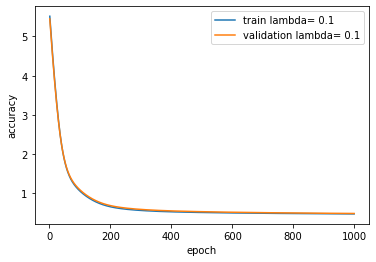

In [ ]:
####### This bunch of code is used to plot ########
plt.plot(range(1,1000+1), train_loss1)
plt.plot(range(1,1000+1), val_loss1)
# plt.plot(range(1,2000+1), train_loss2)
# plt.plot(range(1,2000+1), val_loss2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train lambda= 0.1','validation lambda= 0.1',], loc='upper right')
# plt.show()
plt.savefig("acc_reg_logisticGD_train_val")

In [ ]:
##### find the predictions #######

(test_y, test_X, test_ids) =load_csv_data("test.csv")
test_X = prepare_test_data(test_X, mu, sigma,degree=9)
y_pred = predict_labels(weight,test_X)
create_csv_submission(test_ids,y_pred, "fatima1.csv")